# Zionist archive

Watermarks were removed and are available on Google Storage data/zio/remove_watermarks/

Locally, files were deleted that were not suitable - e.g. containing text / borders

### Check the source data

In [1]:
from dataflows import Flow, load, printer
from glob import glob

# these sources are generated using the zio-* pipelines in the pipeline-spec.yaml

SCRAPE_DETAILS_DATAPACKAGE_JSON = '../wikiscraper/final-data/zio/scrape_details/datapackage.json'
REMOVED_WATERMARK_FILES_PATH = '../wikiscraper/data/zio/remove_watermark/files'

def get_removed_watermark_files():
    for f in glob(f'{REMOVED_WATERMARK_FILES_PATH}/*'):
        yield {'removed_watermark_file': f}

Flow(
    get_removed_watermark_files(),
    load(SCRAPE_DETAILS_DATAPACKAGE_JSON), 
    printer(tablefmt='html', num_rows=1)).process()[1]


#,removed_watermark_file (string)
1,../wikiscraper/data/zio/remove_watermark/files/rownum_4390.png
2,../wikiscraper/data/zio/remove_watermark/files/rownum_5631.png
...,
3553,../wikiscraper/data/zio/remove_watermark/files/rownum_751.png


#,description (string),year (year),id (string),thumb_url (string),details_url (string),scrape_year (year),page_number (integer),rownum (integer),error (string),author (string),copyright (string),item_path (string),photo_type (string),image_url (string),error (string),dedication (string)
1,"מז'יבוז' בפודוליה, בית - הכנסת של הבעלש""ט, ( 1700) .",1700,PHPS\1337102,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\18\\d4\\65.jpg&store=thumbnail_store_01,ArchiveItem.aspx?oi=09001e158065d8ed&ot=cza_photo,1700,1,0,,לא ידוע,בידי הארכיון,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHPS - אוסף שרות התצלומים,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e158065d8ed&objType=cza_photo&scanPage=1,,
2,"מאיר אנשיל רוטשילד, אבי משפחת הרוטשילדים, ( 1743-1812) .",1743,PHG\1019039,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\17\\18\\7f.jpg&store=thumbnail_store_01,ArchiveItem.aspx?oi=09001e158062c865&ot=cza_photo,1743,1,0,,לא ידוע,בידי הארכיון,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHG - האוסף הכללי,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e158062c865&objType=cza_photo&scanPage=1,,
...,,,,,,,,,,,,,,,,
7459,פוטרט של ריצ'רד ליכטנשטיין,1947,KH4\3434-1p,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\02\\6a\\97.jpg&store=thumbnail_store_03,ArchiveItem.aspx?oi=09001e1581825b11&ot=cza_photo,1947,11,11,,לא ידוע,,/הארכיון הציוני/1. חטיבות ואוספים/KH - קרן היסוד/KH4 - קרן היסוד הלשכה הראשית ירושלים/KH4\3434,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e1581825b11&objType=cza_photo&scanPage=1,,


{}

### Create the details_removed_watermark package

This package includes all the zio details rows which have a corresponding removed watermark image

In [2]:
from dataflows import Flow, printer, checkpoint
from zio_flows import details_removed_watermark

!{'rm -rf .checkpoints/zio_details_removed_watermark'}

Flow(
    details_removed_watermark(SCRAPE_DETAILS_DATAPACKAGE_JSON, REMOVED_WATERMARK_FILES_PATH),
    checkpoint('zio_details_removed_watermark'),
    printer(tablefmt='html', num_rows=1),
).process()

saving checkpoint to: .checkpoints/zio_details_removed_watermark


{'rows_with_valid_photo': 3552, 'rows_with_invalid_photo': 3907}


#,description (string),year (year),id (string),thumb_url (string),details_url (string),scrape_year (year),page_number (integer),rownum (integer),error (string),author (string),copyright (string),item_path (string),photo_type (string),image_url (string),error (string),dedication (string),removed_watermark_file (string)
1,"מז'יבוז' בפודוליה, בית - הכנסת של הבעלש""ט, ( 1700) .",1700,PHPS\1337102,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\18\\d4\\65.jpg&store=thumbnail_store_01,http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158065d8ed&ot=cza_photo,1700,1,0,,לא ידוע,בידי הארכיון,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHPS - אוסף שרות התצלומים,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e158065d8ed&objType=cza_photo&scanPage=1,,,../wikiscraper/data/zio/remove_watermark/files/rownum_0.png
2,"הרב אלקלעי יהודה מראשוני חובבי ציון, ( 1878-1788) .",1788,PHPS\1337862,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\18\\db\\2f.jpg&store=thumbnail_store_01,http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158065e031&ot=cza_photo,1788,1,8,,לא ידוע,בידי הארכיון,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHPS - אוסף שרות התצלומים,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e158065e031&objType=cza_photo&scanPage=1,,,../wikiscraper/data/zio/remove_watermark/files/rownum_8.png
...,,,,,,,,,,,,,,,,,
3552,ירושלים- 1948 - התור לנפט/סולר ברחובות העיר,1947,PHL\1088860,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\58\\39.jpg&store=thumbnail_store_01,http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158065468f&ot=cza_photo,1947,10,7445,,לא ידוע,בידי הארכיון,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHL - אוסף פילדלפיה,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e158065468f&objType=cza_photo&scanPage=1,,,../wikiscraper/data/zio/remove_watermark/files/rownum_7445.png


checkpoint saved: zio_details_removed_watermark


(<datapackage.package.Package at 0x7f0a9e696a90>,
 {'count_of_rows': 3552,
  'bytes': 2388308,
  'hash': '878178e6b363019910147bf3e279ee1f',
  'dataset_name': None})

using checkpoint data from .checkpoints/zio_details_removed_watermark


author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: שידור רדיו של ה- .P.B.C מבית זקנים בירושלים, ( 1933) ,
  ( השדרן לוברני) .'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bc89&ot=cza_photo
error: null
id: PHO\1355403
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bc89&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5590.png
rownum: 5590
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\04.jpg&store=thumbnail_store_01
year: 1933




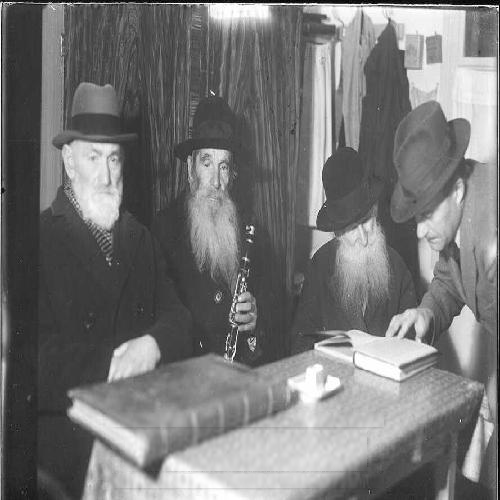

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: החגיגות לרגל יום הולדתו ה- 70 של מנחם אוסישקין, ירושלים,
  ( 10.10.1933) . ( תלמידי בתי ספר עם דגליהם, בטכס שנערך באחת השכונות העבריות; מופע
  של תלמידים רוקדים; טכס אמפיתאטרון האוניברסיטה על הר - הצופים: בן גוריון; הרב בר
  - אילן; לייב יפה; מאגנ'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bcbe&ot=cza_photo
error: null
id: PHO\1355203
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bcbe&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5591.png
rownum: 5591
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\22.jpg&store=thumbnail_store_01
year: 1933




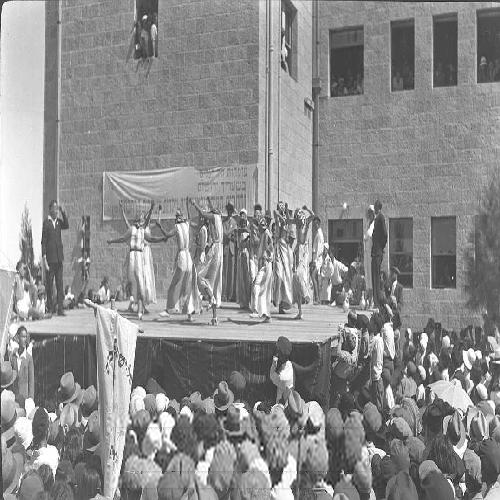

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: החלפת כוחות צבא בתחנת הרכבת בירושלים, ( 21.12.1933) .
  הגעתו של ה-1 St. Bri. Seaforth Highlanders ועזיבתו של Royal Ulster Rifles . ( חיילים
  סקוטיים; קציני משטרה וצבא; תזמורת המשטרה; הנציב ווקופ; משפחת של חיילים? קצינים?
  בריטיים) .'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bccd&ot=cza_photo
error: null
id: PHO\1355313
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bccd&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5592.png
rownum: 5592
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\2a.jpg&store=thumbnail_store_01
year: 1933




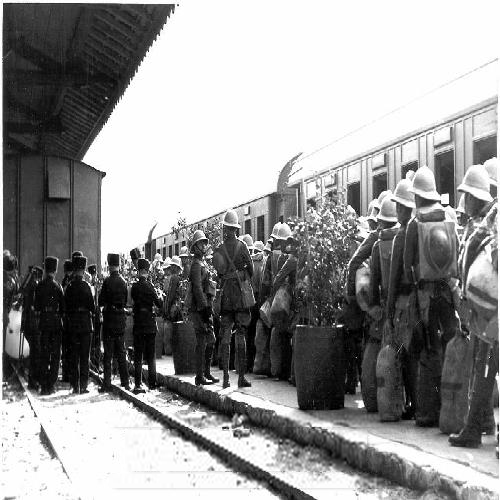

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: משחק גמר באליפות פולו, במועדון הפולו, סרפנד? ( 15.10.1933)
  .'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bccf&ot=cza_photo
error: null
id: PHO\1355239
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bccf&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5593.png
rownum: 5593
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\2c.jpg&store=thumbnail_store_01
year: 1933




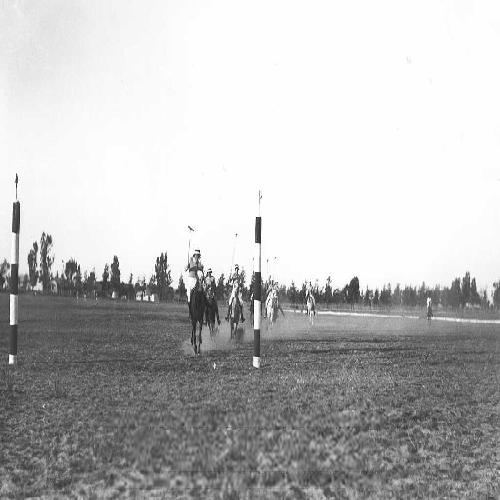

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: יום ספורט של חיל הספר העבר- ירדני ( .T.J.F.F ) בצמח, (
  26.10.1933) . ( המלך עבדאללה; הנציב ווקופ; קית - רואץ''; פקידי ממשל בריטיים; שוטרים
  וקציני משטרה; בדואים; תחרויות רכיבה; תרגילי התעמלות; תזמורת חיילים סקוטיים) .'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bcde&ot=cza_photo
error: null
id: PHO\1355265
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bcde&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5594.png
rownum: 5594
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\32.jpg&store=thumbnail_store_01
year: 1933




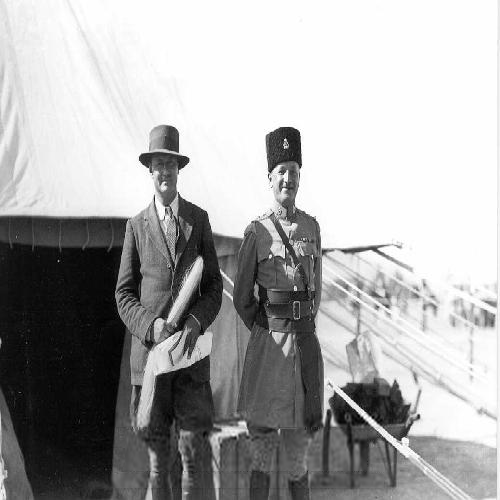

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: משחק הכדורגל הראשון במגרש ימק"א , ( YMCA ) , ( שוטרים בריטיים) , ( 1.4.1933)
  .
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bd0b&ot=cza_photo
error: null
id: PHO\1354762
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bd0b&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5595.png
rownum: 5595
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\53.jpg&store=thumbnail_store_01
year: 1933




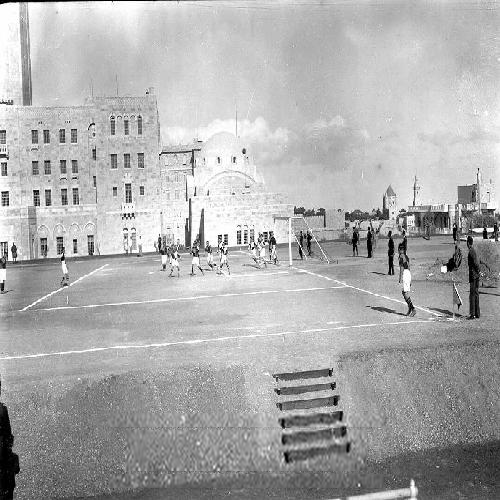

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: החגיגות לרגל יום הולדתו ה- 70 של מנחם אוסישקין, ירושלים,
  ( 10.10.1933) . ( תלמידי בתי ספר עם דגליהם, בטכס שנערך באחת השכונות העבריות; מופע
  של תלמידים רוקדים; טכס אמפיתאטרון האוניברסיטה על הר - הצופים: בן גוריון; הרב בר
  - אילן; לייב יפה; מאגנ'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bd39&ot=cza_photo
error: null
id: PHO\1355224
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bd39&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5596.png
rownum: 5596
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\78.jpg&store=thumbnail_store_01
year: 1933




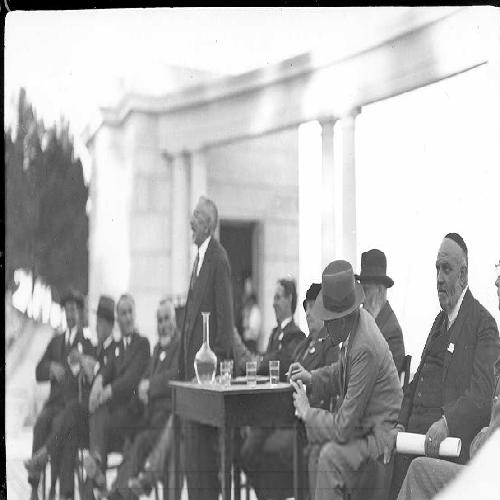

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: 1) מלכת חבש עם הנסיכה טסאי והנסיך מקונן, בעת ביקורה בירושלים,
  ובחנוכת כנסייה חדשה על הירדן, ( 26.9.1933) . 2) הנסיכה טסאי, ירושלים, ( 24.9.1933)
  ( ראה מידע משלים ב" תיק רשימות" ) . ( אנשי כמורה חבשי; קורסים; פקידי ממשל בריטים;
  שוטרים; מסדר ש'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bd57&ot=cza_photo
error: null
id: PHO\1355163
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bd57&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5597.png
rownum: 5597
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\8c.jpg&store=thumbnail_store_01
year: 1933




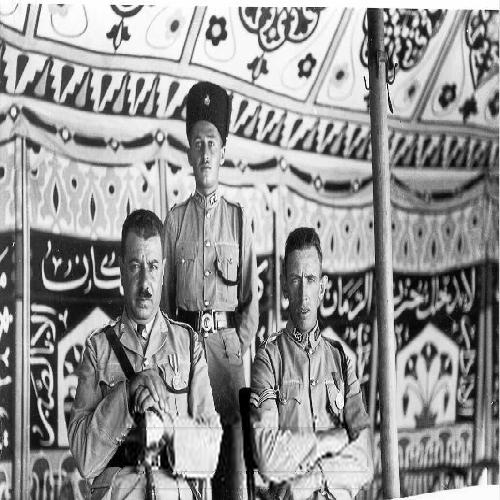

author: אורון צבי (ארושקעס)
copyright: בידי הארכיון
dedication: null
description: 'אורון נושאים: 1) מלכת חבש עם הנסיכה טסאי והנסיך מקונן, בעת ביקורה בירושלים,
  ובחנוכת כנסייה חדשה על הירדן, ( 26.9.1933) . 2) הנסיכה טסאי, ירושלים, ( 24.9.1933)
  ( ראה מידע משלים ב" תיק רשימות" ) . ( אנשי כמורה חבשי; קורסים; פקידי ממשל בריטים;
  שוטרים; מסדר ש'
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158063bd59&ot=cza_photo
error: null
id: PHO\1355161
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e158063bd59&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHO - אוסף צבי אורון (אורושקעס)
page_number: 10
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5598.png
rownum: 5598
scrape_year: 1933
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\68\\8e.jpg&store=thumbnail_store_01
year: 1933




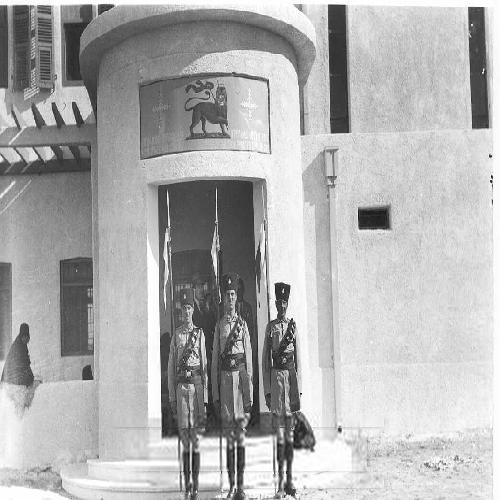

author: לא ידוע
copyright: בידי הארכיון
dedication: null
description: קבוצת רודגס סמוך לפתח תקוה. גידול עופות במקום.
details_url: http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e1580662c41&ot=cza_photo
error: null
id: PHKH\1262542
image_url: /Pages/CzaAjax.ashx?a=viewscan&objId=09001e1580662c41&objType=cza_photo&scanPage=1
item_path: /הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHKH - אוסף קרן היסוד
page_number: 1
photo_type: null
removed_watermark_file: ../wikiscraper/data/zio/remove_watermark/files/rownum_5621.png
rownum: 5621
scrape_year: 1934
thumb_url: https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\05\\0e\\07.jpg&store=thumbnail_store_01
year: 1934




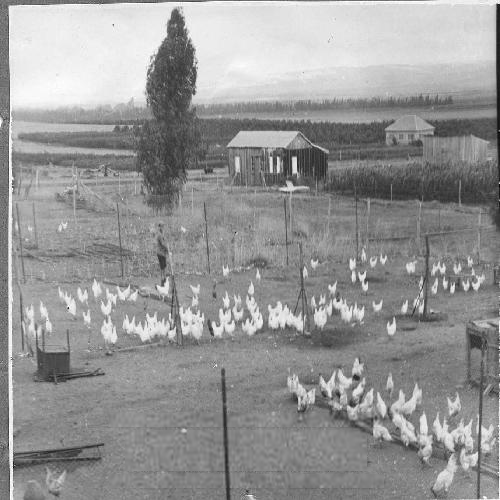

defaultdict(<class 'int'>, {'num_pages': 356, 'last_page_rows': 2})


In [24]:
from dataflows import Flow, checkpoint
from IPython.core.display import display, HTML
import base64
from collections import defaultdict
import yaml

SHOW_IDS = [
    'PHG\1018974', ''
]

stats = defaultdict(int)

def show_zio_images(rows_per_page=10, page_number=0):
    stats['num_pages'] += 1
    
    def _show_zio_images(row):
        if stats['last_page_rows'] >= rows_per_page:
            stats['last_page_rows'] = 0
            stats['num_pages'] += 1
        if stats['num_pages'] == page_number:
            removed_watermark_file = row['removed_watermark_file']
            with open(removed_watermark_file, 'rb') as f:
                data_uri = base64.b64encode(f.read()).decode('utf-8').replace('\n', '')
            id = row['id']
            display(HTML(f'<b>{id}</b>'))
            print(yaml.dump(row, default_flow_style=False, allow_unicode=True))
            display(HTML(f'<img src="data:image/png;base64,{data_uri}"></img>'))
        stats['last_page_rows'] += 1

    return Flow(
        checkpoint('zio_details_removed_watermark'),
        _show_zio_images
    )
                         
Flow(
    show_zio_images(page_number=260)
).process()
                         
print(stats)

## Prepare the data for upload

In [7]:
from collections import defaultdict
import base64
from IPython.core.display import display, HTML
import yaml
from dataflows import Flow, checkpoint, printer, add_field

PREVV_SHOW_IDS = ['PHG\1019933', 'PHG\1018974', 'PHG\1015643', 'PHG\1015643', 'PHG\1052683', 'PHG\1011361', 'PHPS\1339895', '']
PREV_SHOW_PAGE_NUMBERS = [100, 107, 184, 220, 260]

SHOW_IDS = []
SHOW_PAGE_NUMBERS = [101, 108, 185, 221, 261, 266, 289, 305, 315, 350, 355]

!{'rm -rf .checkpoints/zio_removed_watermark_wikicommons_metadata'}

def process_rows():
    rows_per_page = 10
    stats = defaultdict(int)
    
    def _process_rows(rows):
        stats['num_pages'] += 1
        for row in rows:
            if stats['last_page_rows'] >= rows_per_page:
                stats['last_page_rows'] = 0
                stats['num_pages'] += 1
            if stats['num_pages'] in SHOW_PAGE_NUMBERS or row['id'] in SHOW_IDS:
                removed_watermark_file = row['removed_watermark_file']
                with open(removed_watermark_file, 'rb') as f:
                    data_uri = base64.b64encode(f.read()).decode('utf-8').replace('\n', '')
                id = row['id']
                if len(row['description']) > 6 and row['year'] <= 1947:
                    # display(HTML(f'<b>{id}</b>'))
                    # print(yaml.dump(row, default_flow_style=False, allow_unicode=True))
                    # display(HTML(f'<img src="data:image/png;base64,{data_uri}"></img>'))
                    row['file_page_title'] = row['description'][:80] + '-{}.png'.format(row['id'])
                    for char in ['"', "'", '[', ']', ',']:
                        row['file_page_title'] = row['file_page_title'].replace(char, '')
                    page_text = """=={{int:filedesc}}==
{{Information
|description={{he|1=__DESCRIPTION__}}
|date=__YEAR__
|source={{he|1=הארכיון הציוני המרכזי}}
|author={{he|1=הארכיון הציוני המרכזי}}
|permission=
|other versions=
|other fields={{Information field|Name=The Central Zionist Archives Identifier|Value=__PIC_ID__}}
}}
=={{int:license-header}}==
{{PD-Israel}}
{{Supported by Wikimedia Israel|year=2018}}
[[Category:Files from The Central Zionist Archive uploaded by Wikimedia Israel]]"""
                    page_text = page_text.replace('__DESCRIPTION__', row['description'])
                    page_text = page_text.replace('__YEAR__', str(row['year']))
                    page_text = page_text.replace('__PIC_ID__', str(row['id']))
                    row['page_text'] = page_text
                    yield row
            stats['last_page_rows'] += 1
        print(stats)
        
    
    return Flow(
        add_field('file_page_title', 'string'),
        add_field('page_text', 'string'),
        _process_rows,
    )

Flow(
    checkpoint('zio_details_removed_watermark'),
    process_rows(),
    printer(tablefmt='html', num_rows=1, fields=['id', 'removed_watermark_file', 'file_page_title', 'page_text']),
    checkpoint('zio_removed_watermark_wikicommons_metadata')
).process()[1]


saving checkpoint to: .checkpoints/zio_removed_watermark_wikicommons_metadata
using checkpoint data from .checkpoints/zio_details_removed_watermark


defaultdict(<class 'int'>, {'num_pages': 356, 'last_page_rows': 2})


#,id (string),removed_watermark_file (string),file_page_title (string),page_text (string)
1,PHG\1002279,../wikiscraper/data/zio/remove_watermark/files/rownum_2375.png,וולפסון דוד נשיא ההסתדרות הציונית בקושטא ( 1909).-PHG\1002279.png,"=={{int:filedesc}}== {{Information |description={{he|1=וולפסון , דוד נשיא ההסתדרות הציונית בקושטא ( 1909).}} |date=1909 |source={{he|1=הארכיון הציוני המרכזי}} |author={{he|1=הארכיון הציוני המרכזי}} |permission= |other versions= |other fields={{Information field|Name=The Central Zionist Archives Identifier|Value=PHG\1002279}} }} =={{int:license-header}}== {{PD-Israel}} {{Supported by Wikimedia Israel|year=2018}} [[Category:Files from The Central Zionist Archive uploaded by Wikimedia Israel]]"
2,PHG\1003936,../wikiscraper/data/zio/remove_watermark/files/rownum_2376.png,תל- אביב אסיפת היסוד בחולות ( 1909)-PHG\1003936.png,=={{int:filedesc}}== {{Information |description={{he|1=תל- אביב אסיפת היסוד בחולות ( 1909)}} |date=1909 |source={{he|1=הארכיון הציוני המרכזי}} |author={{he|1=הארכיון הציוני המרכזי}} |permission= |other versions= |other fields={{Information field|Name=The Central Zionist Archives Identifier|Value=PHG\1003936}} }} =={{int:license-header}}== {{PD-Israel}} {{Supported by Wikimedia Israel|year=2018}} [[Category:Files from The Central Zionist Archive uploaded by Wikimedia Israel]]
...,,,,
104,PHL\1088872,../wikiscraper/data/zio/remove_watermark/files/rownum_7443.png,ירושלים 1948 - הרס הרובע היהודית של העיר העתיקה-PHL\1088872.png,=={{int:filedesc}}== {{Information |description={{he|1=ירושלים 1948 - הרס הרובע היהודית של העיר העתיקה}} |date=1947 |source={{he|1=הארכיון הציוני המרכזי}} |author={{he|1=הארכיון הציוני המרכזי}} |permission= |other versions= |other fields={{Information field|Name=The Central Zionist Archives Identifier|Value=PHL\1088872}} }} =={{int:license-header}}== {{PD-Israel}} {{Supported by Wikimedia Israel|year=2018}} [[Category:Files from The Central Zionist Archive uploaded by Wikimedia Israel]]


checkpoint saved: zio_removed_watermark_wikicommons_metadata


{'count_of_rows': 104,
 'bytes': 150888,
 'hash': 'c5342cc2d754d0b6ccde3583b8c3d6d5',
 'dataset_name': None}

## Upload

In [10]:
from dataflows import Flow, checkpoint, printer
from collections import defaultdict
import pywikibot
from contextlib import contextmanager
import os
import datetime
import logging
import time

MAX_UPLOADS=150
SKIP_UPLOADS=50

@contextmanager
def throttle(delay_seconds=None):
    delay_seconds = int(os.environ.get("THROTTLE_SECONDS", "15")) if not delay_seconds else delay_seconds
    if hasattr(throttle, 'last_call'):
        seconds_since_last_call = (datetime.datetime.now() - throttle.last_call).seconds
        if seconds_since_last_call < delay_seconds:
            logging.info("throttling {} seconds...".format(delay_seconds - seconds_since_last_call))
            time.sleep(delay_seconds - seconds_since_last_call)
    yield
    throttle.last_call = datetime.datetime.now()

def wikicommons_upload(max_uploads, skip_uploads=0):
    
    def _upload(file_page_title, page_text, image_path, image_id, stats):
        site = pywikibot.Site()
        site.login()
        page = pywikibot.FilePage(site, file_page_title)
        assert page.site.family == 'commons', 'invalid page site: {}'.format(page.site)
        with throttle():
            if not page.exists():
                page.text = page_text
                try:
                    if page.upload(image_path, comment='uploaded by wmilbot', ignore_warnings=True):
                        print("----- {} uploaded successfully".format(image_id))
                        stats['uploaded'] += 1
                    else:
                        raise Exception("Upload failed")
                except Exception:
                    logging.exception(f'failed to upload image_id: {image_id}')
            else:
                page.get()
                page.text = page_text
                page.save(summary='update by wmilbot')
                print('----- {} updated successfully'.format(image_id))
                stats['updated'] += 1
    
    def _wikicommons_upload(rows):
        stats = defaultdict(int)
        for row in rows:
            stats['num_uploads'] += 1
            if skip_uploads <= stats['num_uploads'] <= max_uploads:
                _upload(row['file_page_title'], row['page_text'], row['removed_watermark_file'], row['id'], stats)
                yield row
        print(stats)
    
    return Flow(
        _wikicommons_upload
    )

Flow(
    checkpoint('zio_removed_watermark_wikicommons_metadata'),
    wikicommons_upload(max_uploads=MAX_UPLOADS, skip_uploads=SKIP_UPLOADS),
    printer(tablefmt='html', num_rows=1)
).process()[1]

using checkpoint data from .checkpoints/zio_removed_watermark_wikicommons_metadata


----- PHAL\1620703 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHAL\1620702 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHAL\1620700 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHAL\1620699 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1261495 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1261494 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHAL\1621313 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- GNAR\331078 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHAL\1617966 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088144 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088143 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088142 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088141 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088140 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1089241 uploaded successfully


VERBOSE:pywiki:Found 1 commons:commons processes running, including this one.
Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1261425 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1261424 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1261423 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1261422 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1261421 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088415 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088414 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088413 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088375 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005623 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005651 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005674 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005672 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005670 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005667 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005665 uploaded successfully


VERBOSE:pywiki:Found 1 commons:commons processes running, including this one.
Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005346 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005344 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1005342 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262947 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262946 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262945 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262944 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262943 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262942 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262941 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262948 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHG\1025052 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHKH\1262599 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670961 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670959 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670969 uploaded successfully


VERBOSE:pywiki:Found 1 commons:commons processes running, including this one.
Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670962 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670960 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670970 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670963 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670968 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- NZO\670966 uploaded successfully


Upload successful.
INFO:pywiki:Upload successful.


----- PHL\1088872 uploaded successfully
defaultdict(<class 'int'>, {'num_uploads': 104, 'uploaded': 54})


#,description (string),year (year),id (string),thumb_url (string),details_url (string),scrape_year (year),page_number (integer),rownum (integer),error (string),author (string),copyright (string),item_path (string),photo_type (string),image_url (string),error (string),dedication (string),removed_watermark_file (string),file_page_title (string),page_text (string)
1,"סיור בא""י של הצלם ד""ר פרנץ אקשטיין (Eckstein), בודנבך, צ'כיה, 1935. בתמונה: מסעדה בחוף קאליה, ים המלח.",1935,PHAL\1620704,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\13\\13\\0c.jpg&store=thumbnail_store_01,http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158066fa4c&ot=cza_photo,1935,5,5792,,לא ידוע,בידי הצלם,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHAL - אוסף האלבומים,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e158066fa4c&objType=cza_photo&scanPage=1,,,../wikiscraper/data/zio/remove_watermark/files/rownum_5792.png,סיור באי של הצלם דר פרנץ אקשטיין (Eckstein) בודנבך צכיה 1935. בתמונה: מסעד-PHAL\1620704.png,"=={{int:filedesc}}== {{Information |description={{he|1=סיור בא""י של הצלם ד""ר פרנץ אקשטיין (Eckstein), בודנבך, צ'כיה, 1935. בתמונה: מסעדה בחוף קאליה, ים המלח.}} |date=1935 |source={{he|1=הארכיון הציוני המרכזי}} |author={{he|1=הארכיון הציוני המרכזי}} |permission= |other versions= |other fields={{Information field|Name=The Central Zionist Archives Identifier|Value=PHAL\1620704}} }} =={{int:license-header}}== {{PD-Israel}} {{Supported by Wikimedia Israel|year=2018}} [[Category:Files from The Central Zionist Archive uploaded by Wikimedia Israel]]"
2,"סיור בא""י של הצלם ד""ר פרנץ אקשטיין (Eckstein), בודנבך, צ'כיה, 1935. בתמונה: מבט על הירדן.",1935,PHAL\1620703,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\13\\13\\0b.jpg&store=thumbnail_store_01,http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e158066fa4b&ot=cza_photo,1935,5,5793,,לא ידוע,בידי הצלם,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHAL - אוסף האלבומים,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e158066fa4b&objType=cza_photo&scanPage=1,,,../wikiscraper/data/zio/remove_watermark/files/rownum_5793.png,סיור באי של הצלם דר פרנץ אקשטיין (Eckstein) בודנבך צכיה 1935. בתמונה: מבט -PHAL\1620703.png,"=={{int:filedesc}}== {{Information |description={{he|1=סיור בא""י של הצלם ד""ר פרנץ אקשטיין (Eckstein), בודנבך, צ'כיה, 1935. בתמונה: מבט על הירדן.}} |date=1935 |source={{he|1=הארכיון הציוני המרכזי}} |author={{he|1=הארכיון הציוני המרכזי}} |permission= |other versions= |other fields={{Information field|Name=The Central Zionist Archives Identifier|Value=PHAL\1620703}} }} =={{int:license-header}}== {{PD-Israel}} {{Supported by Wikimedia Israel|year=2018}} [[Category:Files from The Central Zionist Archive uploaded by Wikimedia Israel]]"
...,,,,,,,,,,,,,,,,,,,
55,ירושלים 1948 - הרס הרובע היהודית של העיר העתיקה,1947,PHL\1088872,https://app.jafi.org.il/cza/thumbsrv/getThumbnail?path=00001e15\\80\\08\\58\\5d.jpg&store=thumbnail_store_01,http://www.zionistarchives.org.il/Pages/ArchiveItem.aspx?oi=09001e15806546bb&ot=cza_photo,1947,10,7443,,לא ידוע,בידי הארכיון,/הארכיון הציוני/2. חטיבות ואוספי תצלומים/PHL - אוסף פילדלפיה,,/Pages/CzaAjax.ashx?a=viewscan&objId=09001e15806546bb&objType=cza_photo&scanPage=1,,,../wikiscraper/data/zio/remove_watermark/files/rownum_7443.png,ירושלים 1948 - הרס הרובע היהודית של העיר העתיקה-PHL\1088872.png,=={{int:filedesc}}== {{Information |description={{he|1=ירושלים 1948 - הרס הרובע היהודית של העיר העתיקה}} |date=1947 |source={{he|1=הארכיון הציוני המרכזי}} |author={{he|1=הארכיון הציוני המרכזי}} |permission= |other versions= |other fields={{Information field|Name=The Central Zionist Archives Identifier|Value=PHL\1088872}} }} =={{int:license-header}}== {{PD-Israel}} {{Supported by Wikimedia Israel|year=2018}} [[Category:Files from The Central Zionist Archive uploaded by Wikimedia Israel]]


{}